In [1]:
import sys; sys.path.append("../..") # use local neural_maxwell package

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from pdb import set_trace as breakpoint
from time import time

import numpy as np
import matplotlib.pyplot as plt

from neural_maxwell.datasets.generators import Cavity2D
from neural_maxwell.constants import *
from neural_maxwell.utils import pbar, tensor_diff, tensor_roll

In [2]:
device = torch.device('cuda:0')

In [7]:
class MaxwellConv2D(nn.Module):
    
    def __init__(self, size=32, src_x=16, batch_size=50, supervised=False):
        super().__init__()
        
        self.size = size
        self.src_x = src_x
        self.supervised = supervised
        self.cavity_buffer=4
        self.total_size = self.size + 2 * self.cavity_buffer

#         
#         self.convnet0 = self.make_convolutional_mininet(1, [128, 256, 128, 1], [3, 3, 3, 3]) # 16 in, 8 out
#         self.convnet1 = self.make_convolutional_mininet(2, [128, 256, 128, 1], [5, 5, 5, 5]) # 32 in, 16 out
#         self.convnet2 = self.make_convolutional_mininet(2, [256, 512, 256, 1], [9, 9, 9, 9]) # 64 in, 32 out
        
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=7, stride=1, padding=0),
            nn.ReLU()
        )
        out_size = size-2-4-6
        
        self.densenet = nn.Sequential(
            nn.Linear(out_size**2 * 32, out_size**2 * 32),
            nn.ReLU(),
            nn.Linear(out_size**2 * 32, out_size**2 * 32),
            nn.ReLU(),
        )

        self.invconvnet = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=7, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=0),
        )
    
        # store angler operators
        curl_op, eps_op = Cavity2D(device_length=self.size, cavity_buffer=self.cavity_buffer).get_operators()
        self.curl_curl_op = torch.tensor([np.asarray(np.real(curl_op))]*batch_size, device=device).float()  
    
#         self.layer_dims = [, self.size]

#         layers_amp = []
#         layers_phi = []
#         for i in range(len(self.layer_dims) - 1):
#             layers_amp.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1]))
#             layers_phi.append(nn.Linear(self.layer_dims[i], self.layer_dims[i+1], bias=False))
#         self.layers_amp = nn.ModuleList(layers_amp)
#         self.layers_phi = nn.ModuleList(layers_phi)
        
    @staticmethod
    def make_convolutional_mininet(num_input_channels, channels, kernel_sizes):
        layers = []
        in_channels = num_input_channels
        for out_channels, kernel_size in zip(channels, kernel_sizes):
            layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=0))
            layers.append(nn.ReLU())
            in_channels = out_channels
        return nn.Sequential(*layers)
    
    def get_fields(self, epsilons):
        batch_size, W, H = epsilons.shape
        out = epsilons.view(batch_size, 1, W, H)
        
        out = self.convnet(out)
        _, c, w2, h2 = out.shape
        
        out = out.view(batch_size, -1)
        out = self.densenet(out)
        
        out = out.view(batch_size, c, w2, h2)
        out = self.invconvnet(out)
        
        out = out.view(batch_size, W, H)
        
        return out
        
#         in0 = F.interpolate(eps, scale_factor=1/4)
#         in1 = F.interpolate(eps, scale_factor=1/2)
#         in2 = eps
        
#         out0 = self.convnet0(in0)
        
#         in1 = torch.cat((in1, F.interpolate(out0, scale_factor=4)), 1)
#         out1 = self.convnet1(in1)
        
#         in2 = torch.cat((in2, F.interpolate(out1, scale_factor=4)), 1)
#         out2 = self.convnet2(in2)
        
#         out = out2.view(batch_size, 32)
        
#         return out
        
        
#     def forward_amplitude_phase(self, epsilons):
#         # Get convolutional output
#         x = self.forward_convolutional(epsilons)
        
#         A = x
#         for i, layer in enumerate(self.layers_amp):
#             A = layer(A)
#             if i < len(self.layers_amp) - 1:
#                 A = nn.ReLU()(A)
                
#         phi = x
#         for i, layer in enumerate(self.layers_phi):
#             phi = layer(phi)
#             if i < len(self.layers_amp) - 1:
#                 phi = nn.ReLU()(phi)
        
#         return A, phi
    
#     def get_fields(self, epsilons):
#         # Get amplitude and phase vectors
#         A, phi = self.forward_amplitude_phase(epsilons)
            
#         # Combine to form waveform
#         x = (PIXEL_SIZE * (torch.arange(self.size, dtype=torch.float, device=device) - self.src_x))
#         fields = A * torch.cos(OMEGA / C * torch.sqrt(epsilons) * x + phi)
        
#         return fields
    
    def forward(self, epsilons):        
        # Compute Ez fields
        fields = self.get_fields(epsilons)
        
        if self.supervised:
            labels = torch.empty_like(fields)
            for i, perm in enumerate(epsilons.detach().numpy()):
                _, _, _, _, Ez = Cavity2D(cavity_buffer=16).solve(perm, omega=OMEGA_1550)
                labels[i, :] = torch.tensor(np.imag(Ez[16:-16])).float()
            return fields - labels
        
        else:
            batch_size, _, _ = epsilons.shape

            # Add zero field amplitudes at edge points for resonator BC's
            E = F.pad(fields, [self.cavity_buffer]*4)
            E = E.view(batch_size, -1, 1)

            # Add first layer of cavity BC's
            eps = F.pad(epsilons, [self.cavity_buffer]*4, "constant", -1e20)
            eps = eps.view(batch_size, -1, 1)

            # Compute Maxwell operator on fields
            curl_curl_E = (SCALE / L0**2) * torch.bmm(self.curl_curl_op, E).view(batch_size, -1, 1)
            epsilon_E = (SCALE * -OMEGA**2 * MU0 * EPSILON0) * eps * E

            # Compute free-current vector
            J = torch.zeros(batch_size, self.total_size, self.total_size, device=device)
            J[:, self.src_x + self.cavity_buffer, self.src_x + self.cavity_buffer] = -1.526814027933079 
            J = J.view(batch_size, -1, 1)

            out = curl_curl_E - epsilon_E - J
            out = out.view(batch_size, self.total_size, self.total_size)
            out = out[:, self.cavity_buffer:-self.cavity_buffer, self.cavity_buffer:-self.cavity_buffer]

            return out        

In [8]:
class Perm2dDataset(Dataset):
    
    def __init__(self, epsilon_generator, kernel_sizes = [], N=10000, size=32, infinite_mode=False):
        self.size = size
        self.epsilon_generator = epsilon_generator
        self.epsilon_samples = []
        self.N = N
        self.infinite_mode = infinite_mode
        
    def __len__(self):
        return int(self.N)

    def __getitem__(self, i):
        if i >= len(self.epsilon_samples) or self.infinite_mode:
            epsilons = torch.tensor(self.epsilon_generator())
            if not self.infinite_mode:
                self.epsilon_samples.append(epsilons)
            return epsilons
        else:
            epsilons = self.epsilon_samples[i]
            return epsilons

In [9]:
def perm_rectangle(s=32):
    p_matrix = np.ones((s, s))
    x0, y0 = np.random.randint(10, s - 10, 2)
    dx, dy = np.random.randint(5, 10, 2)
    p_matrix[x0:x0 + dx, y0:y0 + dy] = eps_sio2
    return p_matrix


def perm_ellipse(s=32):
    p_matrix = np.ones((s, s))
    x0, y0 = np.random.randint(10, s - 10, 2)
    rx, ry = np.random.randint(5, 10, 2)

    x, y = np.meshgrid(np.arange(s), np.arange(s))
    ellipse = ((x - x0) / rx) ** 2 + ((y - y0) / ry) ** 2 <= 1
    p_matrix[ellipse < 1.0] = eps_sio2
    return p_matrix

In [10]:
# Hyperparameters
num_epochs = 300
learning_rate = 1e-5
# batch_size = 512
batch_size = 50


# Device configuration
device = torch.device('cuda:0')
# device = torch.device('cpu')

# Create a model   
model = MaxwellConv2D().to(device)

# writer = SummaryWriter()

# Create data loaders
train_data = Perm2dDataset(perm_rectangle, N=1e5, infinite_mode=False)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Perm2dDataset(perm_rectangle, N=1e3, infinite_mode=False)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

# Loss and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=0.001)
# losses = []

# Train the model
model.train()
total_step = len(train_loader)
epoch_iterator = pbar(range(num_epochs))
params = []

for epoch in epoch_iterator:
    
    SHOW_ITERATION_PROGRESS = True
    if SHOW_ITERATION_PROGRESS:
        train_loader = pbar(train_loader)
        
    for epsilons in train_loader:
        
        epsilons = epsilons.float().to(device)
        
        # Forward pass
        outputs = model(epsilons)
        loss = criterion(outputs, torch.zeros_like(outputs))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
        
        if SHOW_ITERATION_PROGRESS:
            train_loader.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)
    epoch_iterator.set_description("ℒ = {:.1e}".format(loss.item()), refresh=False)

# Save the model checkpoint
torch.save(model.state_dict(), 'model_2d_conv.ckpt')

KeyboardInterrupt: 

In [11]:
epsilons = perm_rectangle()
model.eval()
fields = model.get_fields(torch.tensor([epsilons]).to(device).float())[0].cpu().detach().numpy()

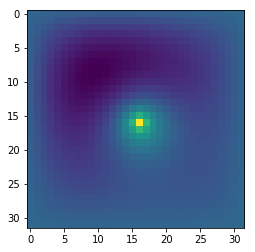

In [12]:
plt.imshow(fields)

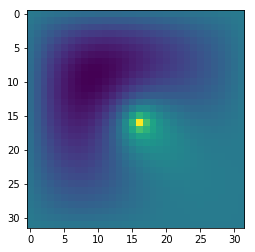

In [13]:
perms, _, _, _, _, Ez = Cavity2D(device_length=len(epsilons), cavity_buffer=4).solve(epsilons, omega=OMEGA_1550)
Ez = np.real(Ez)[4:-4, 4:-4]
plt.imshow(Ez)

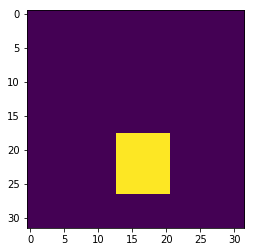

In [54]:
plt.imshow(perms)